<a href="https://colab.research.google.com/github/Shnku/pythoning_stuff/blob/proj/NN/training_expr1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Classification and recognization

## Mount google-drive & Load dataset

In [128]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

data_path = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    data_path = root_path + "/Expr1_CNC_BuildingClassify_filtered_data"
    for filename in os.listdir(data_path):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
Training_data
Validate_data
Testing_data_mix
resnet18_image_classifier_last_87.pth
old_copy
model_with_82_accy_resnt18.pth
model_with_68_accy_resnt18.pth
classify_training_tst_expr1.ipynb
model_with_58_accy_resnt18.pth
model_with_75_accy_resnt18.pth
Copy of classify_training_tst_expr1.ipynb
Copy of load_saved_model_and_test.ipynb
load_saved_model_and_test.ipynb
resnet18_image_classifier_full.pth


In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Specify training and testing data path

In [131]:
path_train_data= data_path + "/Training_data"
path_test_data= data_path + "/Validate_data"

## Importing pytorch and setup CPU or GPU

In [132]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Define data transformations

In [133]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=224

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    # transforms.RandomRotation(10),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

In [134]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=path_train_data, transform=train_transform)
test_dataset = ImageFolder(root=path_test_data, transform=test_transform)

print(train_dataset)
print(f'data classes are: {train_dataset.classes}')
print(test_dataset)
print(f'data classes are: {test_dataset.classes}')

Dataset ImageFolder
    Number of datapoints: 120
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Expr1_CNC_BuildingClassify_filtered_data/Training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
data classes are: ['admin', 'chemistry', 'gurudeb', 'heritage']
Dataset ImageFolder
    Number of datapoints: 29
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/Expr1_CNC_BuildingClassify_filtered_data/Validate_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolati

## Visualization of transformation

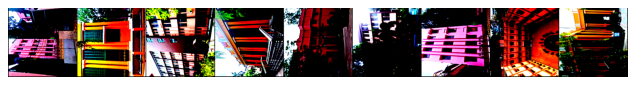

labels: tensor([2, 3, 0, 3, 1, 0, 2, 2, 3])


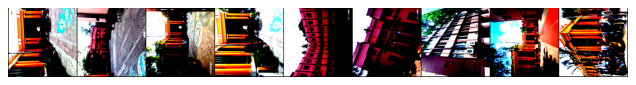

labels: tensor([3, 1, 3, 3, 2, 1, 0, 3, 3])


In [135]:
def disp_img_grid(dataset):
    loader = DataLoader(dataset, batch_size=9, shuffle=True)
    batch = next(iter(loader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=1)
    plt.figure(figsize=(10, 10),dpi=80)
    # Use permute instead of calling the tensor
    plt.imshow(np.transpose(grid.permute(1, 2, 0).numpy(), (1, 0, 2)))
    plt.axis('off')  # Hide axes
    plt.show()  # Show the plot
    print(f'labels: {lbl}')

disp_img_grid(train_dataset)
disp_img_grid(test_dataset)

## Data loader

In [136]:
BATCH_SIZE = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_loader)

## Use Readymade CNN Model(ResNet) and modify it

In [137]:
# Load pre-trained ResNet18 model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# rsnt18_model = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
rsnt18_model = models.resnet18(weights = None) # pretrained = False)

# modifying the last layer
last_layer_in = rsnt18_model.fc.in_features
no_of_classes = len(train_dataset.classes)
print(f"last layer output for model = {last_layer_in} -> convert to {no_of_classes} output")
rsnt18_model.fc = nn.Linear(last_layer_in, no_of_classes)

last layer output for model = 512 -> convert to 4 output


In [138]:
# Move model to device
rsnt18_model = rsnt18_model.to(DEVICE)
print(rsnt18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [139]:
loss_fn = nn.CrossEntropyLoss() # criterion = torch.nn.CrossEntropyLoss()
print(loss_fn)
optimizer = optim.Adam(rsnt18_model.parameters(), lr=0.001)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Training part

In [140]:
def train_NN(model, train_loader, test_loader, loss_citr, optim, n_epochs=10):
    """
    Trains a neural network model over multiple epochs.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset (unused in the provided snippet but typically for validation).
        loss_citr (torch.nn.Module): The loss function (e.g., CrossEntropyLoss).
        optim (torch.optim.Optimizer): The optimizer (e.g., Adam, SGD).
        n_epochs (int): The number of training epochs.
    """
    # Outer loop: Iterate through the specified number of training epochs
    for epoch in range(n_epochs):
        print(f'epoch number--- {epoch}') # Informative print statement for current epoch

        # Set the model to training mode
        model.train()

        # Initialize metrics for the current epoch's training phase
        running_loss = 0.0      # Accumulates loss over batches in the epoch
        running_correct = 0     # Accumulates count of correctly predicted samples
        total = 0               # Accumulates total samples processed

        # Inner loop: Iterate through each batch of data provided by the train_loader
        for data in train_loader:
            images, labels = data # Unpack the batch: input images and their true labels

            # Move images and labels to the designated training device (e.g., GPU)
            images = images.to(DEVICE) # 'DEVICE' (e.g., 'cuda' or 'cpu') must be defined globally
            labels = labels.to(DEVICE)

            total += labels.size(0) # Add the number of samples in the current batch to the total

            # --- Core Training Steps ---

            # 1. Zero the gradients: Clear any gradients accumulated from previous steps/batches.
            optim.zero_grad()

            # 2. Forward Pass: Feed the images through the model to get raw predictions (logits).
            output = model(images)

            # 3. Get Predicted Class: Convert raw predictions (logits) to predicted class indices.
            #    This is done by finding the index of the highest logit score for each image.
            _, predicted = torch.max(output.data, 1)

            # 4. Calculate Loss: Compute the difference between the model's output and the true labels.
            loss = loss_citr(output, labels)

            # 5. Backward Pass: Compute gradients of the loss with respect to model parameters.
            loss.backward()

            # 6. Optimizer Step: Update model parameters using the calculated gradients.
            optim.step()

            # --- Update Running Metrics ---

            # Accumulate the loss for the current batch
            running_loss += loss.item()

            # Accumulate the number of correctly predicted samples
            running_correct += (labels == predicted).sum().item()

        # After all batches in the epoch are processed:
        # Calculate average loss and accuracy for the current epoch
        epoch_loss = running_loss / len(train_loader) # Average loss per batch
        epoch_accuracy = 100.0 * running_correct / total # Overall accuracy for the epoch

        # Print epoch summary
        print(f'   -Training...got {running_correct} out of {total} correctly {epoch_accuracy:.2f}%, Epoch loss:{epoch_loss:.2f}%')

        # This line is commented out, but in a full training script, you'd typically call
        # your evaluation function here to check performance on a separate validation/test set.
        eval_model_on_test(model,test_loader,train_dataset.classes)

    print("Finished.....") # Indicates training loop has completed

### **Learning and Theoretical Points**

This code exemplifies the standard **training loop** for deep learning models. Understanding each step is crucial for building and debugging neural networks.

---

#### **Epochs (`for epoch in range(n_epochs):`)**

* **The Theory:** An "**epoch**" represents one complete pass through the entire training dataset. Since neural networks learn iteratively, multiple passes over the data are usually required for the model to sufficiently adjust its weights and minimize the loss.
* **Why it Matters:** The `n_epochs` parameter determines how many times the model will see the entire training data. Too few epochs might result in **underfitting** (the model hasn't learned enough), while too many can lead to **overfitting** (the model memorizes the training data but performs poorly on new, unseen data).

---

#### **Training Mode (`model.train()`)**

* **The Theory:** Similar to `model.eval()`, `model.train()` sets the model to its training mode. This reactivates components like **Batch Normalization** (to calculate batch statistics) and **Dropout** (to apply regularization by randomly dropping neurons).
* **Why it Matters:** It ensures that the model's internal layers behave as intended for learning, enabling adaptive normalization and regularization to prevent overfitting. Always remember to switch between `model.train()` and `model.eval()` for their respective phases.

---

#### **Batch Processing (`for data in train_loader:`)**

* **The Theory:** Instead of feeding all data at once (which is memory-intensive for large datasets) or one sample at a time (which is computationally inefficient), neural networks are typically trained in **mini-batches**. A `DataLoader` helps manage this.
* **Why it Matters:**
    * **Memory Efficiency:** Reduces memory consumption by processing only a subset of data at a time.
    * **Computational Efficiency:** Allows for vectorized operations and parallel processing on GPUs, significantly speeding up training.
    * **Gradient Stability:** Provides a more stable estimate of the true gradient compared to single-sample updates, while still introducing enough noise to help escape local minima compared to full-batch training.

---

#### **The Core Training Loop: The Six Steps of Gradient Descent**

This is the most critical part of the code, representing one **optimization step** for a single mini-batch.

##### ***Step 1: Zero Gradients (`optim.zero_grad()`)***

* **The Theory:** Gradients are cumulative in PyTorch by default. This means if you don't clear them, gradients from previous batches would add up, leading to incorrect weight updates.
* **Why it Matters:** Before computing gradients for the current batch, you must zero out the gradients from the previous batch's computations. This ensures that the weight updates are based *only* on the current mini-batch's error.

##### ***Step 2: Forward Pass (`output = model(images)`)***

* **The Theory:** This is where the input data (`images`) is fed through the neural network's layers. The model performs calculations (matrix multiplications, activations, convolutions, etc.) to produce raw output scores (logits) for each class.
* **Why it Matters:** It's how the model makes its predictions based on its current set of learned weights.

##### ***Step 3: Get Predicted Class (`_, predicted = torch.max(output.data, 1)`)***

* **The Theory:** As explained in the previous code breakdown, `torch.max` on the logits identifies the class with the highest score, representing the model's most confident prediction for each input.
* **Why it Matters:** This step translates the raw numerical outputs into concrete class labels, allowing for accuracy calculation.

##### ***Step 4: Calculate Loss (`loss = loss_citr(output, labels)`)***

* **The Theory:** The `loss_citr` (loss criterion or function) quantifies how "wrong" the model's predictions (`output`) are compared to the true labels (`labels`). For classification tasks, common choices include **Cross-Entropy Loss**. A lower loss value means the model's predictions are closer to the truth.
* **Why it Matters:** The loss function provides the objective that the model tries to minimize during training. It's the signal that guides the learning process.

##### ***Step 5: Backward Pass (`loss.backward()`)***

* **The Theory:** This is the core of **backpropagation**. Based on the calculated `loss`, PyTorch's autograd engine automatically computes the gradients of the loss with respect to *every trainable parameter* (weight and bias) in the model. These gradients indicate how much each parameter needs to change to reduce the loss.
* **Why it Matters:** Backpropagation is the algorithm that allows the model to "learn" by identifying the direction and magnitude of changes needed for its internal parameters.

##### ***Step 6: Optimizer Step (`optim.step()`)***

* **The Theory:** The `optim` (optimizer) takes the gradients computed during the backward pass and uses them to update the model's weights and biases. Common optimizers include **Stochastic Gradient Descent (SGD)**, **Adam**, **RMSprop**, etc. Each optimizer has a different strategy for how to use the gradients to update weights.
* **Why it Matters:** This is the actual "learning" step where the model's parameters are adjusted based on the errors it made, aiming to reduce the loss in subsequent forward passes.

---

#### **Training Metrics (Loss and Accuracy)**

* **The Theory:** Tracking `running_loss` and `running_correct` allows you to monitor the training progress throughout an epoch.
* **Why it Matters:**
    * **Loss:** Provides insight into how well the model is minimizing its objective function. A decreasing loss generally indicates learning.
    * **Accuracy:** Gives a human-interpretable measure of correct classifications.
    * Monitoring both helps diagnose issues (e.g., high accuracy but high loss might indicate problems with probability calibration, or just a very easy problem).

---

#### **The Role of `eval_model_on_test` (Commented Out)**

* **The Theory:** While the code snippet has `eval_model_on_test(model,test_loader)` commented out, it's crucial in a real training pipeline. After each epoch, it's best practice to evaluate the model on a separate **validation set** (often referred to as the `test_loader` here, but conceptually distinct from the final, unseen test set).
* **Why it Matters:**
    * **Detecting Overfitting:** By comparing training loss/accuracy to validation loss/accuracy, you can detect if your model is overfitting. If training accuracy keeps increasing while validation accuracy plateaus or decreases, your model is likely memorizing the training data instead of learning general patterns.
    * **Hyperparameter Tuning:** Validation performance guides decisions about hyperparameter tuning (learning rate, batch size, epochs, model architecture).

---

This training loop is the fundamental structure for teaching a neural network. Mastering these steps is key to building effective deep learning models.

epoch number--- 0
   -Training...got 37 out of 120 correctly 30.83%, Epoch loss:1.74%
--Testing... got 9 out of 29 correctly accuracy=(31.03%)


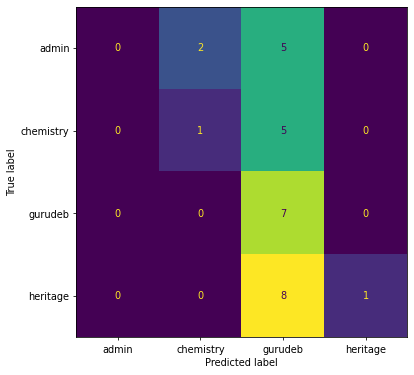

epoch number--- 1
   -Training...got 56 out of 120 correctly 46.67%, Epoch loss:1.25%
--Testing... got 22 out of 29 correctly accuracy=(75.86%)


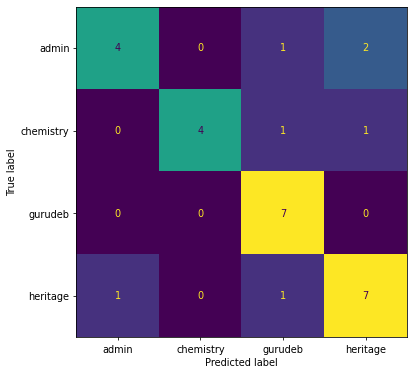

epoch number--- 2
   -Training...got 69 out of 120 correctly 57.50%, Epoch loss:1.04%
--Testing... got 21 out of 29 correctly accuracy=(72.41%)


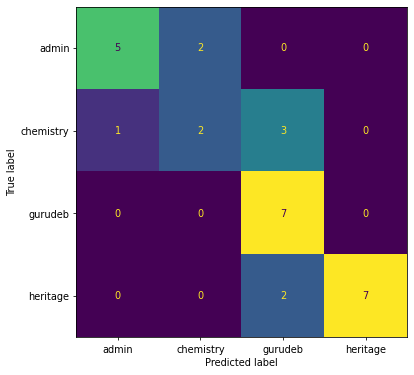

epoch number--- 3
   -Training...got 74 out of 120 correctly 61.67%, Epoch loss:1.11%
--Testing... got 21 out of 29 correctly accuracy=(72.41%)


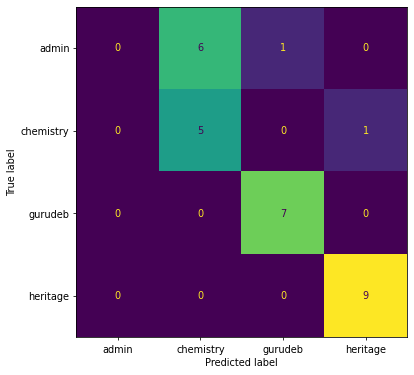

epoch number--- 4
   -Training...got 85 out of 120 correctly 70.83%, Epoch loss:0.84%
--Testing... got 22 out of 29 correctly accuracy=(75.86%)


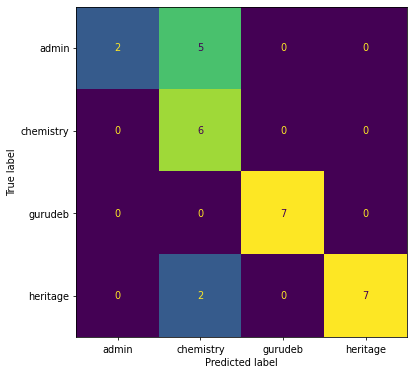

epoch number--- 5
   -Training...got 79 out of 120 correctly 65.83%, Epoch loss:0.81%
--Testing... got 25 out of 29 correctly accuracy=(86.21%)


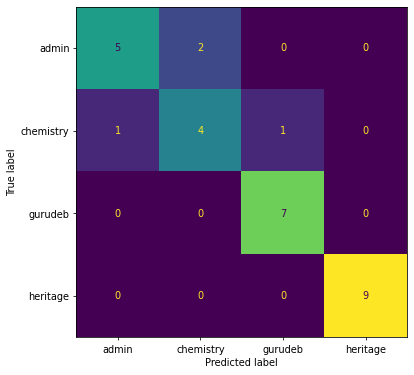

epoch number--- 6
   -Training...got 93 out of 120 correctly 77.50%, Epoch loss:0.62%
--Testing... got 27 out of 29 correctly accuracy=(93.10%)


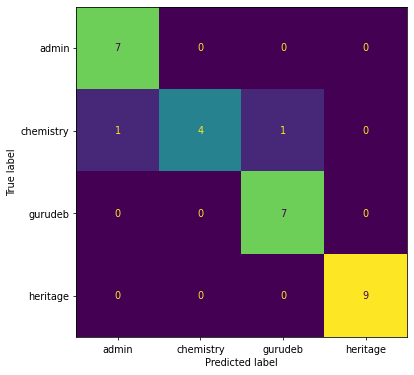

epoch number--- 7
   -Training...got 95 out of 120 correctly 79.17%, Epoch loss:0.52%
--Testing... got 19 out of 29 correctly accuracy=(65.52%)


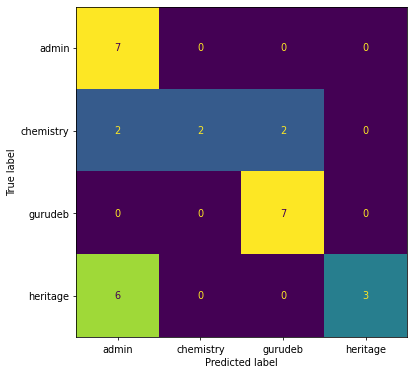

epoch number--- 8
   -Training...got 94 out of 120 correctly 78.33%, Epoch loss:0.55%
--Testing... got 27 out of 29 correctly accuracy=(93.10%)


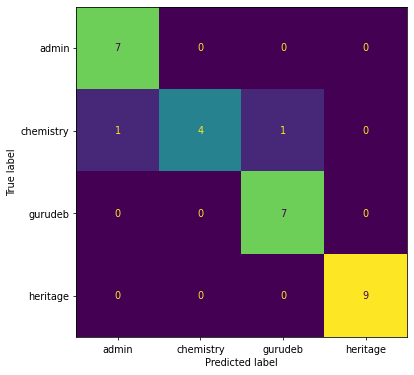

epoch number--- 9
   -Training...got 106 out of 120 correctly 88.33%, Epoch loss:0.40%
--Testing... got 29 out of 29 correctly accuracy=(100.00%)


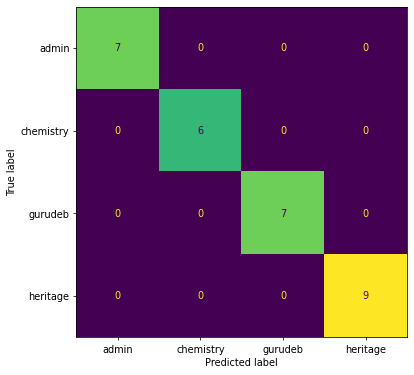

Finished.....


In [141]:
train_NN(rsnt18_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=10)

## Validate the model


In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def eval_model_on_test(model, test_loader, display_labels):
    """
    Evaluates a PyTorch model on a test dataset, calculates accuracy,
    and displays a confusion matrix.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        display_labels (list): A list of class names in the correct order,
                                to be used for the confusion matrix axes.
    """
    model.eval()  # Set the model to evaluation mode

    pred_correctly = 0  # Counter for correctly predicted samples
    total = 0           # Counter for total samples processed
    actual_labels = []  # List to store ground truth labels
    predicted_labels = [] # List to store model's predicted labels

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Iterate over batches in the test_loader
        for i_image, i_label in test_loader:
            # Move images and labels to the specified device (e.g., GPU or CPU)
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            total += i_label.size(0) # Add the number of samples in the current batch to total

            # Perform a forward pass: get raw predictions (logits) from the model
            output = model(i_image)

            # Get the predicted class index (class with the highest probability/logit)
            # torch.max(output.data, 1) returns (max_value, argmax_index) along dimension 1
            # Dimension 1 corresponds to the class scores (e.g., [batch_size, num_classes])
            _, predicted = torch.max(output.data, 1)

            # Sum up the number of correct predictions in the current batch
            pred_correctly += (predicted == i_label).sum().item()

            # Collect actual and predicted labels for the confusion matrix
            # .cpu().numpy() converts PyTorch tensors on GPU back to CPU NumPy arrays
            actual_labels.extend(i_label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate overall accuracy
    accuracy = 100.0 * pred_correctly / total
    print(f'--Testing... got {pred_correctly} out of {total} correctly accuracy=({accuracy:.2f}%)')

    # Generate and display the confusion matrix
    # sklearn.metrics.confusion_matrix computes the matrix from actual and predicted labels
    cm = confusion_matrix(actual_labels, predicted_labels)
    # ConfusionMatrixDisplay is used for plotting the matrix
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=display_labels
    )

    # plt.figure(figsize=(6,6),dpi=40)
       # Create a matplotlib figure and axes with the desired size
    fig, ax = plt.subplots(figsize=(6, 6), dpi=70) # Set the figure size here
    # Plot the confusion matrix onto the created axes
    disp.plot(ax=ax, colorbar=False) # Pass the axes to disp.plot()
    plt.tight_layout() # Ensure the labels fit without overlapping
    plt.show() # Display the plot


### Learning and Theoretical Points

#### Evaluation vs. Training Mode (`model.eval()`)

* **Theoretical Point:** Deep learning models, especially Convolutional Neural Networks (CNNs) like ResNet18, often contain layers whose behavior differs between training and inference (evaluation).
    * **Batch Normalization (BatchNorm):** During training, BatchNorm layers calculate running means and variances of batches to normalize activations. During evaluation, they use the **globally accumulated** running mean and variance learned during training.
    * **Dropout:** During training, Dropout layers randomly "drop out" (set to zero) a fraction of neurons to prevent overfitting. During evaluation, all neurons are kept, and their weights are scaled down by the dropout probability to compensate.
* **Practical Impact:** Calling `model.eval()` is **critical** before evaluation to ensure these layers behave correctly for inference. Failing to do so can lead to inconsistent and often worse performance, as the model might still apply training-specific regularization techniques.

---

#### Disabling Gradient Calculation (`with torch.no_grad():`)

* **Theoretical Point:** During model training, PyTorch's autograd engine builds a computational graph to track operations and calculate gradients for backpropagation.
* **Practical Impact:** During inference, we don't need to compute gradients because we're not updating model weights. The `torch.no_grad()` context manager:
    * **Saves Memory:** It prevents the storage of intermediate activations needed for gradient computation, significantly reducing memory consumption.
    * **Speeds up Computation:** It avoids building the computational graph, leading to faster inference times.
    * **Prevents Accidental Updates:** Ensures that no accidental weight updates occur if you were to perform an operation that might otherwise trigger gradient calculation.

---

#### Device Management (`.to(DEVICE)`)

* **Theoretical Point:** Modern deep learning heavily relies on specialized hardware like GPUs (CUDA devices) for parallel processing and faster computation. Data (images, labels) and the model itself must reside on the same device for operations to be performed.
* **Practical Impact:** `.to(DEVICE)` (where `DEVICE` is typically `'cuda'` for GPU or `'cpu'` for CPU) ensures that the input tensors are moved to the same device where your model is located. This prevents runtime errors and utilizes the chosen hardware acceleration. Similarly, `.cpu().numpy()` converts tensors from GPU back to CPU and then to NumPy arrays, which are required by `sklearn` functions.

---

#### Understanding Model Output (`torch.max(output.data, 1)`)

* **Theoretical Point:** A classification model's final layer typically outputs "logits" or raw scores for each class. These are not probabilities but simply values that indicate the model's confidence for each class.
* **Practical Impact:** `torch.max(output.data, 1)` is used to get the predicted class.
    * `output.data`: Accesses the underlying tensor data directly (though `output` itself is generally fine).
    * `dim=1`: Specifies that the maximum value should be found along dimension 1 (the class dimension). For an output tensor of shape `[batch_size, num_classes]`, this means finding the highest score for each image across its `num_classes` possible predictions.
    * The function returns two tensors: the maximum values themselves, and their corresponding indices. We only care about the indices (`_ , predicted`), as these indices represent the predicted class labels.
    * **Note on Softmax:** While `torch.max` on logits is sufficient to get the predicted class, during training, a `softmax` activation function (often combined with a `CrossEntropyLoss`) is typically applied to convert logits into probabilities, which sum to 1. For inference, taking the `argmax` of the logits directly yields the same predicted class as taking the `argmax` of the softmax outputs, but it's computationally cheaper.

---

#### Accuracy as a Metric

* **Theoretical Point:** Accuracy is the simplest and most intuitive metric: the proportion of correctly classified samples out of the total samples.
    $$Accuracy = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$
* **Limitations:** While easy to understand, accuracy can be misleading, especially in **imbalanced datasets**. If 90% of your test images are "Admin" buildings, a model that always predicts "Admin" would achieve 90% accuracy, even if it performs terribly on other classes. This limitation leads us to the confusion matrix.

---

#### Confusion Matrix (`sklearn.metrics.confusion_matrix`)

* **Theoretical Point:** A confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known. It allows visualization of the performance of an algorithm.
    * **Rows:** Represent the actual (true) classes.
    * **Columns:** Represent the predicted classes.
    * **Diagonal Elements:** Show the number of correct predictions for each class (True Positives for that class).
    * **Off-Diagonal Elements:** Show misclassifications (False Positives and False Negatives for different classes).
* **Practical Value:**
    * **Granular Insight:** It immediately shows *where* your model is getting confused. For example, if your "Heritage" building is often misclassified as "Admin," you'll see a high number in the "Heritage" row, "Admin" column.
    * **Beyond Accuracy:** Helps identify if the model has a strong bias towards one class or struggles with distinguishing between specific pairs of classes. This is crucial for debugging and improving your model.
    * **Foundation for Other Metrics:** It's the basis for calculating precision, recall, F1-score, and specificity for each class.

---

### Confusion matrix

--Testing... got 29 out of 29 correctly accuracy=(100.00%)


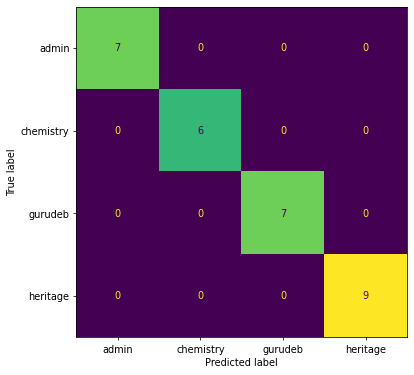

In [143]:
eval_model_on_test(rsnt18_model,test_loader,train_dataset.classes)

## Save trained model

In [144]:
# print(rsnt18_model.state_dict())
# torch.save(rsnt18_model.state_dict(), data_path +'/resnet18_image_classifier.pth')

#save entire model
torch.save(rsnt18_model, data_path +'/resnet18_image_classifier_full.pth')

os.listdir(data_path)

['Training_data',
 'Validate_data',
 'Testing_data_mix',
 'resnet18_image_classifier_last_87.pth',
 'old_copy',
 'model_with_82_accy_resnt18.pth',
 'model_with_68_accy_resnt18.pth',
 'classify_training_tst_expr1.ipynb',
 'model_with_58_accy_resnt18.pth',
 'model_with_75_accy_resnt18.pth',
 'Copy of classify_training_tst_expr1.ipynb',
 'Copy of load_saved_model_and_test.ipynb',
 'load_saved_model_and_test.ipynb',
 'resnet18_image_classifier_full.pth']